In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam


/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Load the data

In [4]:
fake_news=pd.read_csv("ML KNN Overview Fake.txt", header=None)
true_news=pd.read_csv("ML KNN Overview Real.txt", header=None)

In [5]:
fake_news

,0
0,trump warns of vote flipping on machines
1,this election is not about trump its about a g...
2,more on trump populism and how it can be contr...
3,trump bollywood ad meant to sway indian americ...
4,dems could be up on charges for inciting trump...
...,...
1293,what happens if trump loses the election what ...
1294,latest poll shows trump with 4 point lead in f...
1295,breaking donald trump makes major clinton indi...
1296,no hate crimes have not intensified since trum...


## Set the columns name 'text'

In [6]:
fake_news.columns=['text']
true_news.columns=['text']

In [7]:
true_news['label']=1
fake_news['label']=0

## Combine the dataset

In [8]:
news_df=pd.concat([fake_news,true_news])

In [9]:
# Shuffle the dataset
news_df = news_df.sample(frac=1).reset_index(drop=True)

In [10]:

# Preprocessing
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    return text

news_df['text'] = news_df['text'].apply(preprocess_text)

## Spliting the data

In [11]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(news_df['text'], news_df['label'], test_size=0.2, random_state=42)

## Vectorization

In [12]:
vectorizer= TfidfVectorizer(max_features=500)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Define function to plot training history


In [13]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'],label='Training loss')
    plt.plot(history.history['val_loss'],label='Validation loss')
    plt.legend()
    plt.title('Loss over epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'],label='Training Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    
    plt.show()

In [14]:
# Function to plot ROC curve
def plot_roc_curve(y_test,y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test,y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr,tpr,color='darkorange',lw=2,label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [15]:
# Function to evaluate models
def evaluate_model(model, X_trai,y_train,X_test,y_test):
    model.fit(X_trai,y_train)
    y_pred=model.predict(X_test)
    y_pred_prob=model.predict_proba(X_test)[:,1]
    
    accuracy=accuracy_score(y_test,y_pred)
    cm=confusion_matrix(y_test,y_pred)
    report = classification_report(y_test,y_pred)
    
    print(f'Accuracy: {accuracy}')
    print('Confusion Matrix')
    print(cm)
    print(f'Report of Confusion Matrix')
    print(report)
    plot_roc_curve(y_test,y_pred_prob)

## Logistic Regression 

Logistic Regression
Accuracy: 0.8302752293577982
Confusion Matrix
[[194  63]
 [ 48 349]]
Report of Confusion Matrix
              precision    recall  f1-score   support

           0       0.80      0.75      0.78       257
           1       0.85      0.88      0.86       397

    accuracy                           0.83       654
   macro avg       0.82      0.82      0.82       654
weighted avg       0.83      0.83      0.83       654



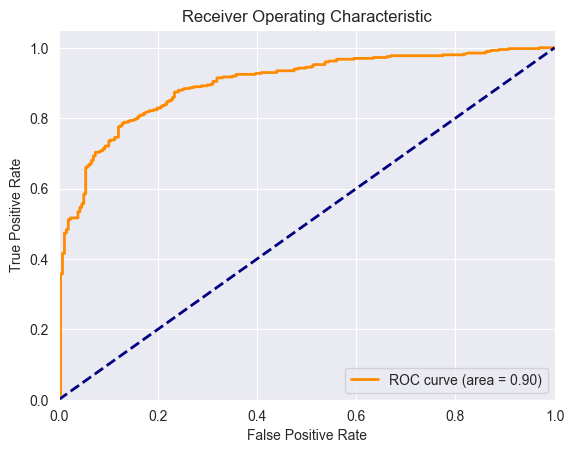

In [16]:
print("Logistic Regression")
logreg=LogisticRegression(max_iter=1000)
evaluate_model(logreg,X_train_tfidf,y_train,X_test_tfidf,y_test)

## Multinomial Naive Bayes

Multinomial Naive Bayes
Accuracy: 0.8211009174311926
Confusion Matrix
[[191  66]
 [ 51 346]]
Report of Confusion Matrix
              precision    recall  f1-score   support

           0       0.79      0.74      0.77       257
           1       0.84      0.87      0.86       397

    accuracy                           0.82       654
   macro avg       0.81      0.81      0.81       654
weighted avg       0.82      0.82      0.82       654



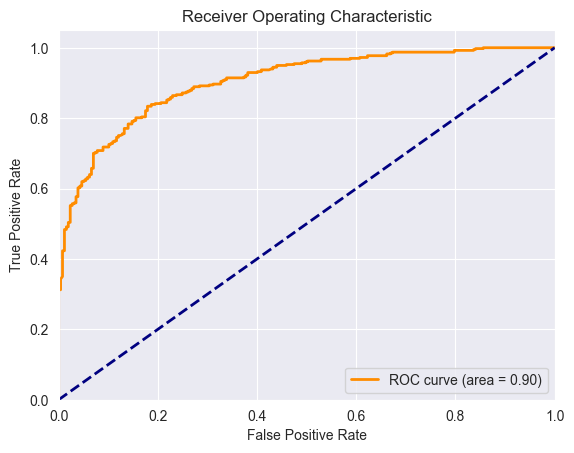

In [17]:
print("Multinomial Naive Bayes")
mnb=MultinomialNB()
evaluate_model(mnb,X_train_tfidf,y_train,X_test_tfidf,y_test)


## Support Vector Machine

Support Vector Machine
Accuracy: 0.8226299694189603
Confusion Matrix
[[195  62]
 [ 54 343]]
Report of Confusion Matrix
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       257
           1       0.85      0.86      0.86       397

    accuracy                           0.82       654
   macro avg       0.82      0.81      0.81       654
weighted avg       0.82      0.82      0.82       654



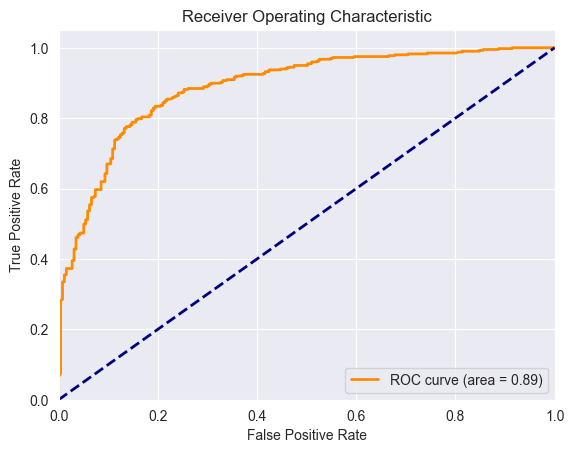

In [18]:
print("Support Vector Machine")
svc=SVC(probability=True)
evaluate_model(svc,X_train_tfidf,y_train,X_test_tfidf,y_test)

## Random Forest

Random Forest
Accuracy: 0.8073394495412844
Confusion Matrix
[[185  72]
 [ 54 343]]
Report of Confusion Matrix
              precision    recall  f1-score   support

           0       0.77      0.72      0.75       257
           1       0.83      0.86      0.84       397

    accuracy                           0.81       654
   macro avg       0.80      0.79      0.80       654
weighted avg       0.81      0.81      0.81       654



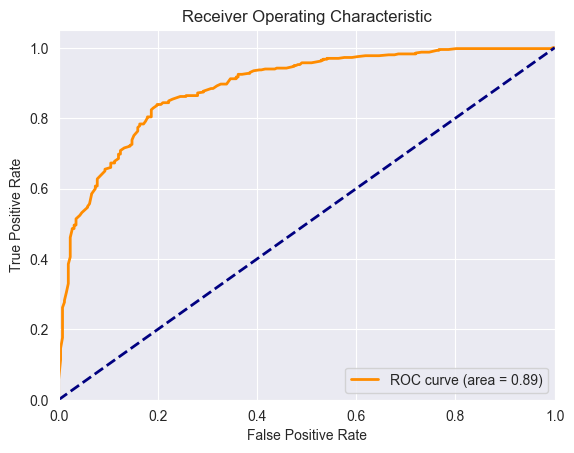

In [19]:
print("Random Forest")
rf=RandomForestClassifier(n_estimators=100)
evaluate_model(rf,X_train_tfidf,y_train,X_test_tfidf,y_test)

## Neural Network

Neural Network
Epoch 1/100


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6118 - loss: 0.6708 - val_accuracy: 0.5927 - val_loss: 0.6300
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6202 - loss: 0.6006 - val_accuracy: 0.7572 - val_loss: 0.5117
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7982 - loss: 0.4785 - val_accuracy: 0.8394 - val_loss: 0.3776
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8720 - loss: 0.3301 - val_accuracy: 0.8489 - val_loss: 0.3562
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8830 - loss: 0.2901 - val_accuracy: 0.8375 - val_loss: 0.3677
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9101 - loss: 0.2451 - val_accuracy: 0.8298 - val_loss: 0.3971
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9219 - loss: 0.2254 - val_accuracy: 0.8241 - val_loss: 0.4208
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9472 - loss: 0.1735 - val_accuracy: 0.8203 - val_loss: 0.

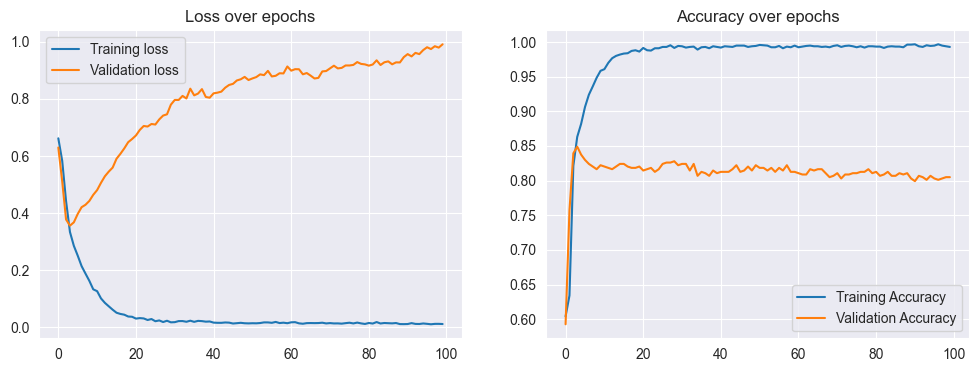

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.8226299694189603
Confusion Matrix: [[203  54]
 [ 62 335]]
Classification Report:               precision    recall  f1-score   support

           0       0.77      0.79      0.78       257
           1       0.86      0.84      0.85       397

    accuracy                           0.82       654
   macro avg       0.81      0.82      0.82       654
weighted avg       0.82      0.82      0.82       654



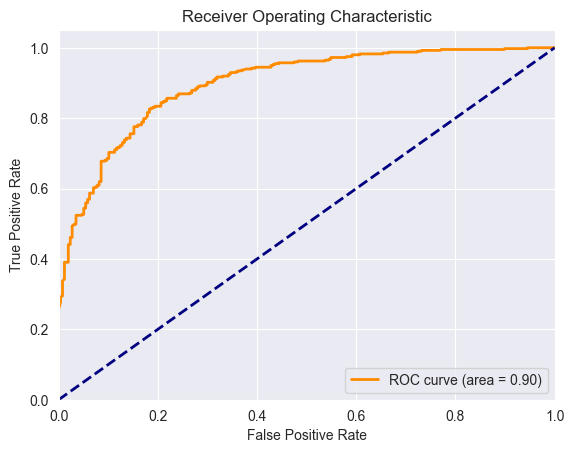

In [20]:
print("Neural Network")
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(512,input_dim=input_dim,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
    return model

nn_model=create_nn_model(X_train_tfidf.shape[1])
history=History()
nn_model.fit(X_train_tfidf.toarray(),y_train,epochs=10, batch_size=128,validation_split=0.2,callbacks=[history])
plot_history(history)

# Evaluate Neural Network

y_pred_prob_nn=nn_model.predict(X_test_tfidf.toarray()).ravel()
y_pred_nn=(y_pred_prob_nn>0.5).astype(int)
print(f'Accuracy: {accuracy_score(y_test,y_pred_nn)}')
print(f'Confusion Matrix: {confusion_matrix(y_test,y_pred_nn)}')
print(f'Classification Report: {classification_report(y_test,y_pred_nn)}')
plot_roc_curve(y_test,y_pred_prob_nn)

In [22]:
# Compare models
results=pd.DataFrame(
    {
        'Model':['Logistic Regression','Multinomial Naive Bayes','Support Vector Machine','Random Forest','Neural Network'],
        'Accuracy':[accuracy_score(y_test, logreg.predict(X_test_tfidf)),
                    accuracy_score(y_test, mnb.predict(X_test_tfidf)),
                    accuracy_score(y_test, svc.predict(X_test_tfidf)),
                    accuracy_score(y_test, rf.predict(X_test_tfidf)),
                    accuracy_score(y_test, y_pred_nn)]
    }
)
print(results)

                     Model  Accuracy
0      Logistic Regression  0.830275
1  Multinomial Naive Bayes  0.821101
2   Support Vector Machine  0.822630
3            Random Forest  0.807339
4           Neural Network  0.822630
